In [ ]:
pip install meteostat

In [ ]:
from meteostat import Point, Daily, Hourly
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Coordinates of Delhi
delhi = Point(28.6139, 77.2090)
# Hourly data from Jan to April 2024
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2024-04-30')
data = Hourly(delhi, start=start_date, end=end_date)
df = data.fetch()

In [ ]:
print(df.head())

                     temp  dwpt   rhum  prcp  snow  wdir  wspd  wpgt    pres  \
time                                                                           
2020-01-01 00:00:00   3.2   3.2  100.0  <NA>  <NA>   0.0   0.0  <NA>  1021.1   
2020-01-01 01:00:00   4.3   4.3  100.0  <NA>  <NA>   0.0   0.0  <NA>  1021.7   
2020-01-01 02:00:00   4.7   4.7  100.0  <NA>  <NA>   0.0   0.0  <NA>  1022.3   
2020-01-01 03:00:00   4.0   3.4   96.0  <NA>  <NA>  70.0   3.6  <NA>  1023.2   
2020-01-01 04:00:00   7.6   5.6   87.0  <NA>  <NA>  96.0   1.8  <NA>  1023.3   

                     tsun  coco  
time                             
2020-01-01 00:00:00  <NA>   5.0  
2020-01-01 01:00:00  <NA>   5.0  
2020-01-01 02:00:00  <NA>   5.0  
2020-01-01 03:00:00  <NA>   5.0  
2020-01-01 04:00:00  <NA>   5.0  


In [ ]:
#Let’s sort and structure the time column:
df = df.reset_index()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df = df.sort_index()

In [ ]:
#Let’s resample to hourly data using mean() (safe for numeric weather):
df_hourly = df.resample('1h').mean()

In [ ]:
#Check for Nan values
df_hourly.isna().sum()

,0
temp,0
dwpt,0
rhum,0
prcp,21060
snow,37945
wdir,36
wspd,0
wpgt,37945
pres,0
tsun,37945


In [ ]:
#Filling missing data
df_filled = df_hourly.ffill()

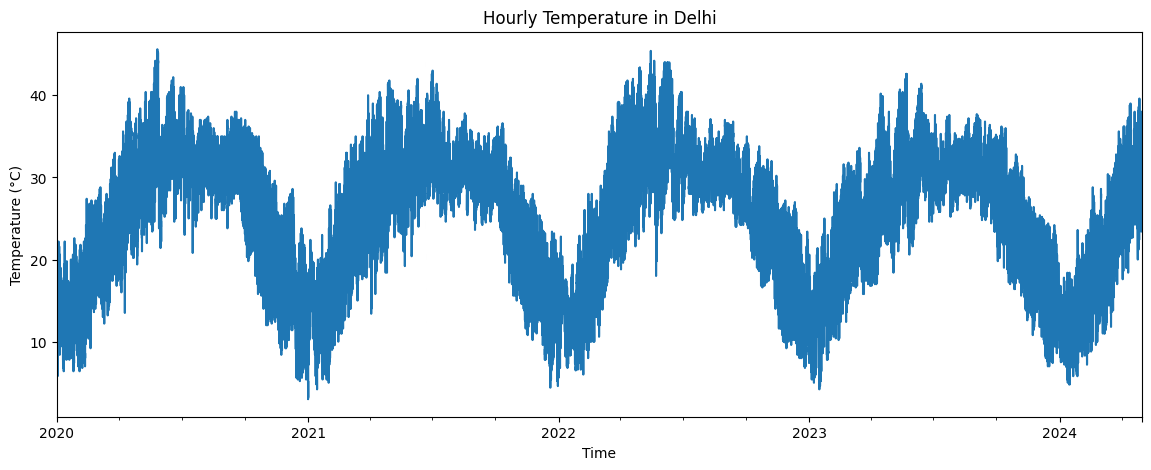

In [ ]:
#Visualize the Cleaned Data
df_filled['temp'].plot(figsize=(14, 5), title="Hourly Temperature in Delhi")
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')
plt.show()

In [ ]:
#Sace cleaned data
df_filled.to_csv("delhi_hourly_weather_clean.csv")

In [ ]:
df_cleaned = pd.read_csv("delhi_hourly_weather_clean.csv", index_col='time', parse_dates=True)
print(df_cleaned.head())

                     temp  dwpt   rhum  prcp  snow  wdir  wspd  wpgt    pres  \
time                                                                           
2020-01-01 00:00:00   3.2   3.2  100.0   NaN   NaN   0.0   0.0   NaN  1021.1   
2020-01-01 01:00:00   4.3   4.3  100.0   NaN   NaN   0.0   0.0   NaN  1021.7   
2020-01-01 02:00:00   4.7   4.7  100.0   NaN   NaN   0.0   0.0   NaN  1022.3   
2020-01-01 03:00:00   4.0   3.4   96.0   NaN   NaN  70.0   3.6   NaN  1023.2   
2020-01-01 04:00:00   7.6   5.6   87.0   NaN   NaN  96.0   1.8   NaN  1023.3   

                     tsun  coco  
time                             
2020-01-01 00:00:00   NaN   5.0  
2020-01-01 01:00:00   NaN   5.0  
2020-01-01 02:00:00   NaN   5.0  
2020-01-01 03:00:00   NaN   5.0  
2020-01-01 04:00:00   NaN   5.0  


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import joblib
import numpy as np

# Data Preparation for regression
# We'll use 'dwpt' (dew point) and 'rhum' (relative humidity) to predict 'temp' (temperature)

X = df_cleaned[['dwpt', 'rhum']].values
y = df_cleaned['temp'].values

# Scale the features (X)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale the target variable (y)
scaler_y = MinMaxScaler()
# Reshape y to be a 2D array as required by MinMaxScaler
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Save the scalers
joblib.dump(scaler_X, 'linear_regression_scaler_X.pkl')
joblib.dump(scaler_y, 'linear_regression_scaler_y.pkl')

print("End")

End


In [ ]:
# Train a Linear Regression model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Train the model on the training data
model_train = LinearRegression()
model_train.fit(X_train, y_train)

# Make predictions on training and validation sets
y_train_pred_scaled = model_train.predict(X_train)
y_val_pred_scaled = model_train.predict(X_val)

# Inverse transform the predictions and actual values to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_train_orig = scaler_y.inverse_transform(y_train)
y_val_orig = scaler_y.inverse_transform(y_val)

# Calculate metrics for training set
train_mse = mean_squared_error(y_train_orig, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_orig, y_train_pred)
train_mape = np.mean(np.abs((y_train_orig - y_train_pred) / y_train_orig)) * 100

# Calculate metrics for validation set
val_mse = mean_squared_error(y_val_orig, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val_orig, y_val_pred)
val_mape = np.mean(np.abs((y_val_orig - y_val_pred) / y_val_orig)) * 100


# Print the metrics
print("Training Metrics:")
print(f"  Mean Squared Error (MSE): {train_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"  R-squared (R2): {train_r2:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {train_mape:.4f}%")

print("\nValidation Metrics:")
print(f"  Mean Squared Error (MSE): {val_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {val_rmse:.4f}")
print(f"  R-squared (R2): {val_r2:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {val_mape:.4f}%")

Training Metrics:
  Mean Squared Error (MSE): 1.9357
  Root Mean Squared Error (RMSE): 1.3913
  R-squared (R2): 0.9720
  Mean Absolute Percentage Error (MAPE): 4.5514%

Validation Metrics:
  Mean Squared Error (MSE): 1.8320
  Root Mean Squared Error (RMSE): 1.3535
  R-squared (R2): 0.9735
  Mean Absolute Percentage Error (MAPE): 4.4775%


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib

# Data Preparation for LSTM
# We'll use 'dwpt' (dew point) and 'rhum' (relative humidity) to predict 'temp' (temperature)

X = df_cleaned[['dwpt', 'rhum']].values
y = df_cleaned['temp'].values

# Scale the features (X)
scaler_X_lstm = MinMaxScaler()
X_scaled_lstm = scaler_X_lstm.fit_transform(X)

# Scale the target variable (y)
scaler_y_lstm = MinMaxScaler()
# Reshape y to be a 2D array as required by MinMaxScaler
y_scaled_lstm = scaler_y_lstm.fit_transform(y.reshape(-1, 1))

# Save the scalers
joblib.dump(scaler_X_lstm, 'lstm_scaler_X.pkl')
joblib.dump(scaler_y_lstm, 'lstm_scaler_y.pkl')


# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the number of time steps
TIME_STEPS = 24 # Using 24 hours of data to predict the next hour

X_sequences, y_sequences = create_sequences(X_scaled_lstm, y_scaled_lstm, TIME_STEPS)

print(f"Shape of X_sequences: {X_sequences.shape}")
print(f"Shape of y_sequences: {y_sequences.shape}")

Shape of X_sequences: (37921, 24, 2)
Shape of y_sequences: (37921, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsolutePercentageError

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_sequences.shape[1], X_sequences.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsolutePercentageError()])
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.0190 - mean_absolute_percentage_error: 1094.6141 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 8.8987
Epoch 2/20
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - loss: 0.0028 - mean_absolute_percentage_error: 190.0643 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 6.4314
Epoch 3/20
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 0.0021 - mean_absolute_percentage_error: 3158.8638 - val_loss: 9.6342e-04 - val_mean_absolute_percentage_error: 5.6415
Epoch 4/20
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0016 - mean_absolute_percentage_error: 2432.5029 - val_loss: 8.7638e-04 - val_mean_absolute_percentage_error: 5.7259
Epoch 5/20
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0013 - mean_absolute_percentage_error: 3158.7053 - val_loss: 8.3158e-04 - val_mean_absolute_percentage_error: 5.0232
Epoch 6/20
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 0.0012 - mean_absolute_percent

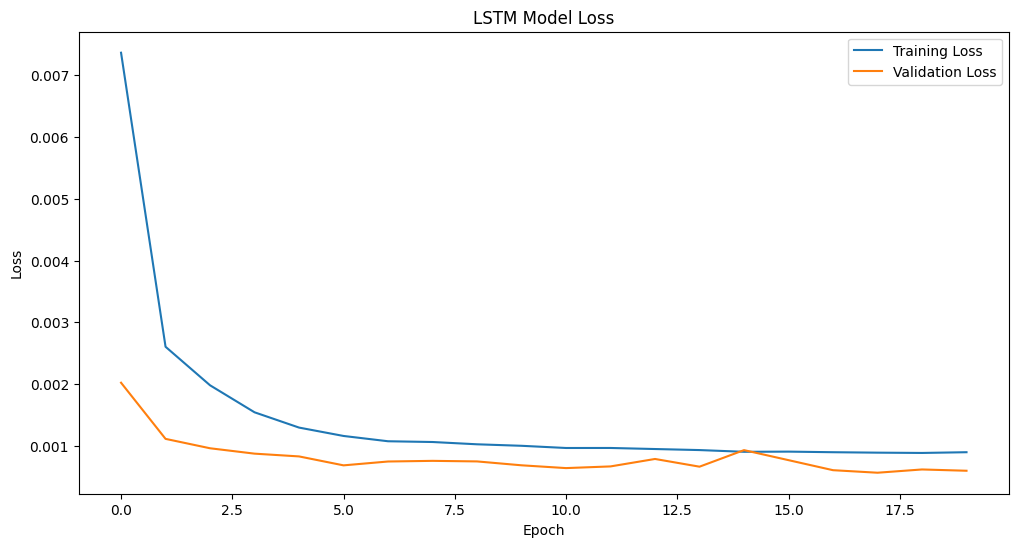


Final Training Loss: 0.0008996134856715798
Final Validation Loss: 0.0005997647531330585

LSTM model saved as 'lstm_model.h5'


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Split data into training and validation sets for LSTM
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Train the LSTM model
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=20, validation_split=0.2)

# Visualize training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print final loss metrics
print("\nFinal Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])

# Save the LSTM model
model_lstm.save('lstm_model.h5')
print("\nLSTM model saved as 'lstm_model.h5'")